In [177]:
import CanDI as can
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition, preprocessing

### Cancer Object Instantiation
I'm interested in studying non-small cell lung cancer using the data in depmap and ccle. I start by instantiating a cancer object that will allow me to explore the data space of non-small cell lung cancer cell lines. Since I don't want any small cell lung cancer cell lines included I will specify a disease subtype during instantiation. The subtype argument of Cancer object instantiation works by string matching in the lineage_subtype collumn of the cell_lines dataset. Below you can see that we have a variety of cell types within a given lineage subtype.

In [140]:
lung = can.Cancer("Lung Cancer", subtype="NSCLC")
lung.subtypes

array(['Non-Small Cell Lung Cancer (NSCLC), Adenocarcinoma',
       'Non-Small Cell Lung Cancer (NSCLC), Large Cell Carcinoma',
       'Non-Small Cell Lung Cancer (NSCLC), unspecified',
       'Non-Small Cell Lung Cancer (NSCLC), Squamous Cell Carcinoma',
       'Non-Small Cell Lung Cancer (NSCLC), Adenosquamous Carcinoma',
       'Non-Small Cell Lung Cancer (NSCLC), Mucoepidermoid Carcinoma'],
      dtype=object)

I want to look at how oncogenic mutations affect global genetic dependencies. Let's choose KRAS and EGFR as our oncogenic mutations. I'm going to make four CellLineCluster objects per oncogene, eight in total. For each oncogene I want a CellLineCluster that is only mutated cell lines, a CellLineCluster that is only wildtype cell lines, and two additional Mutant/Wild type clusters where cell lines with mutations in the other oncogene have been removed. The CellLineClusters are as follows.

##### To Analyze KRAS and Control for EGFR
* Lung - KRAS MT - EGFR *
* Lung - KRAS WT - EGFR *
* Lung - KRAS MT - EGFR WT
* Lung - KRAS MT - EGFR WT

##### To Analyze EGFR and Control for KRAS
* Lung - EGFR MT - KRAS *
* Lung - EGFR WT - KRAS *
* Lung - EGFR MT - KRAS WT
* Lung - EGFR WT - KRAS WT

MT = Mutant \
WT = Wild Type \
\* = unspecified 

In [141]:
#Mutated function automatically ignores silent mutations
kras_mt_ids = lung.mutated("KRAS", variant="Variant_Classification", item = "Missense_Mutation")
egfr_mt_ids = lung.mutated("EGFR", variant="Variant_Classification")

kras_wt_ids = list(set(lung.depmap_ids) - set(kras_mt_ids))
egfr_wt_ids = list(set(lung.depmap_ids) - set(egfr_mt_ids))

kras_mt_ewt_ids = list(set(kras_mt_ids) - set(egfr_mt_ids))
kras_wt_ewt_ids = list(set(kras_wt_ids) - set(egfr_mt_ids))

egfr_mt_kwt_ids = list(set(egfr_mt_ids) - set(kras_mt_ids))
egfr_wt_kwt_ids = list(set(egfr_wt_ids) - set(kras_mt_ids))

#Instantiate KRAS Clusters
kras_mt = can.CellLineCluster(kras_mt_ids)
kras_wt = can.CellLineCluster(kras_wt_ids)
kras_mt_ewt = can.CellLineCluster(kras_mt_ewt_ids)
kras_wt_ewt = can.CellLineCluster(kras_wt_ewt_ids)

#Instantiate EGFR Clusters
egfr_mt = can.CellLineCluster(egfr_mt_ids)
egfr_wt = can.CellLineCluster(egfr_wt_ids)
egfr_mt_kwt = can.CellLineCluster(egfr_mt_kwt_ids)
egfr_wt_kwt = can.CellLineCluster(egfr_wt_kwt_ids)

#### Analyzing Global Gene Dependency
To see how KRAS and EGFR mutations affect global gene dependency I'm going to plot the average gene effect for every gene of the mutant and wildtype clusters against each other. This if gene effect skews towards wildtype or mutation status for any give gene. The Function below will be used to make this plot. Unless you are interested in specifically how this plot is made you can skip the following cell.

In [142]:
def gene_effect_scatter(mt, wt, mt_wt, wt_wt, gene, control, tc1=None, tc2=None, name=None):
    
    #Average Gene Effect for control agnostic groups
    mt_effect = mt.gene_effect.mean(1)
    wt_effect = wt.gene_effect.mean(1)
    #Average Gene Effect for controlled gorups
    mt_wt_effect = mt_wt.gene_effect.mean(1)
    wt_wt_effect = wt_wt.gene_effect.mean(1)
    
    #For Labeling
    mt_lab = mt_effect.loc[[gene, control]]
    wt_lab = wt_effect.loc[[gene, control]]
    mt_wt_lab = mt_wt_effect.loc[[gene, control]]
    wt_wt_lab = wt_wt_effect.loc[[gene, control]]
    
    
    #Make Figure appropriate size, dpi, and font
    plt.rcParams.update({"figure.figsize": (8, 8),
                        "savefig.dpi": 300,
                        "font.family": "sans-serif",
                        "font.size": 12
                        })
    
    #Generate Figure and Axis objects
    fig, ax = plt.subplots(1,1)
    
    #Label Axes
    ax.set_xlabel(f"{gene} MT Average Gene Effect (CERES Score)")
    ax.set_ylabel(f"{gene} WT Average Gene Effect (CERES Score)")
    
    #Draw Line at median common essential value
    ax.axhline(y = -1.0,
               c = "black",
               linewidth=0.5,
               label = "Median Common Essential Gene Effect"
              )
    ax.axvline(x = -1.0,
               c= "black",
               linewidth=0.5)
    #Plot all genes
    ax.scatter(mt_effect,
               wt_effect,
               c = "#e41a1c",
               alpha = 0.8,
               s = 50,
               label = f"{control} MT or WT",
               marker = "^"
              )
    #Plot all Genes, control 
    ax.scatter(mt_wt_effect,
               wt_wt_effect,
               c = "#377eb8",
               s = 35,
               alpha = 0.5,
               label = f"{control} WT"
              )
    #Outline Genes To label
    ax.scatter(mt_lab,
               wt_lab,
               c = "#e41a1c",
               alpha = 1,
               s = 50,
               edgecolor = "black",
               linewidth = 2,
               marker = "^"
              )
    #Outline Genes to label
    ax.scatter(mt_wt_lab,
               wt_wt_lab,
               c = "#377eb8",
               alpha = 1,
               s = 35,
               edgecolor = "black",
               linewidth = 2,
              )
    ax.legend()
    
    #Label control agnostic Series
    if tc1:
        for i in range(mt_lab.shape[0]):
            text = list(mt_lab.index)
            ax.annotate(text[i],
                        xy = (mt_lab[i], wt_lab[i]),
                        xytext = tc1[i],
                        xycoords = "data",
                        arrowprops = {"arrowstyle": "-"}
                       )
    #Label control wild type series
    if tc2:
        for i in range(mt_wt_lab.shape[0]):
            text = list(mt_wt_lab.index)
            ax.annotate(text[i],
                        xy = (mt_wt_lab[i], wt_wt_lab[i]),
                        xytext = tc2[i],
                        xycoords = "data",
                        arrowprops = {"arrowstyle": "-"}
                       )
    
    plt.show()
    
    if name:
        fig.savefig(name, dpi=300)
        
    return



#### Note about Gene Effect Scores: Dependency vs Essentiality
A more negative gene effect means more dependent. A gene effect of -1.0 is the median gene effect of all common essential genes. If a gene has a gene effect of -1.0 or lower it then that gene is essential. A cell line can still be dependent on a gene with a lower gene effect if knocking out that gene slows growth/proliferation. 

#### Average Gene Effect in KRAS Wildtype and KRAS Mutant Cell Lines
KRAS dependency heavily favors KRAS mutant cell lines. No other gene's depedencies are as skewed toward KRAS mutant cell lines. KRAS mutations appear to be self essentializing.

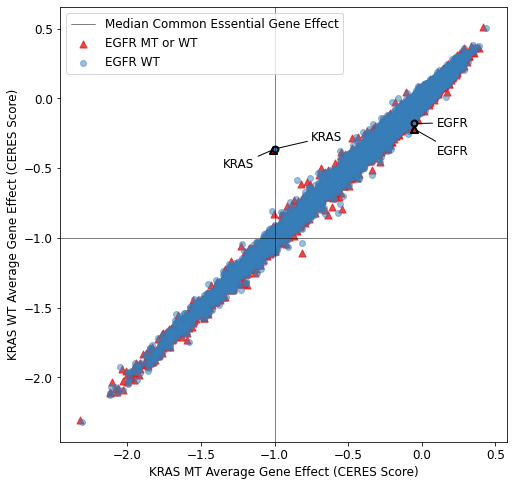

In [143]:
#Text_coords are custom per graph 
text_coords1 = [(-1.35, -0.5), (0.1, -0.4)]
text_coords2 = [(-0.75, -0.3), (0.1, -0.2)]

gene_effect_scatter(kras_mt,
                    kras_wt,
                    kras_mt_ewt,
                    kras_wt_ewt,
                    "KRAS",
                    "EGFR",
                    tc1 = text_coords1,
                    tc2 = text_coords2,
                    name= None)


#### Average Gene Effect of EGFR MT vs EGFR WT Cell Lines
We don't observed the same self esentializing effect with EGFR and EGFR mutations as we do with KRAS and KRAS mutations. The KRAS point moves upwards along the diaganol when KRAS mutant cell lines are removed, indicating the self essentializing effect of KRAS mutations was represented equally in both EGFR mutant and EGFR wild type cell lines. 

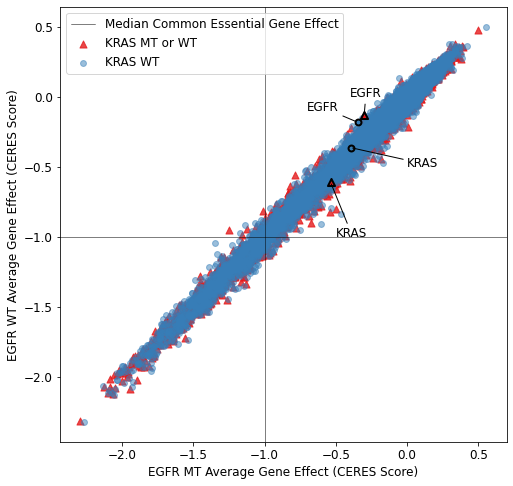

In [144]:
tc1 = [(-0.4, 0), (-0.5, -1)]
tc2 = [(-0.7, -0.1), (0.0,-0.5)]
gene_effect_scatter(egfr_mt,
                    egfr_wt,
                    egfr_mt_kwt,
                    egfr_wt_kwt,
                    "EGFR",
                    "KRAS",
                    tc1 = tc1,
                    tc2 = tc2,
                    name = None
                   )

In [394]:
dep = lung.gene_dependency
dep = dep.where(dep >= 0.5).fillna(0)
dep = dep.where(dep < 0.5).fillna(1)
dep = dep.astype(int)

to_show = dep.var(1).sort_values(ascending=False).iloc[:1000,]
to_show

gene
BTAF1     0.252688
ATP5PF    0.252688
COX6C     0.252688
ENY2      0.252688
SOWAHC    0.252688
            ...   
LIG3      0.156486
UBE2G2    0.156486
HSD3B1    0.156486
DCAF15    0.156486
TRUB2     0.156486
Length: 1000, dtype: float64

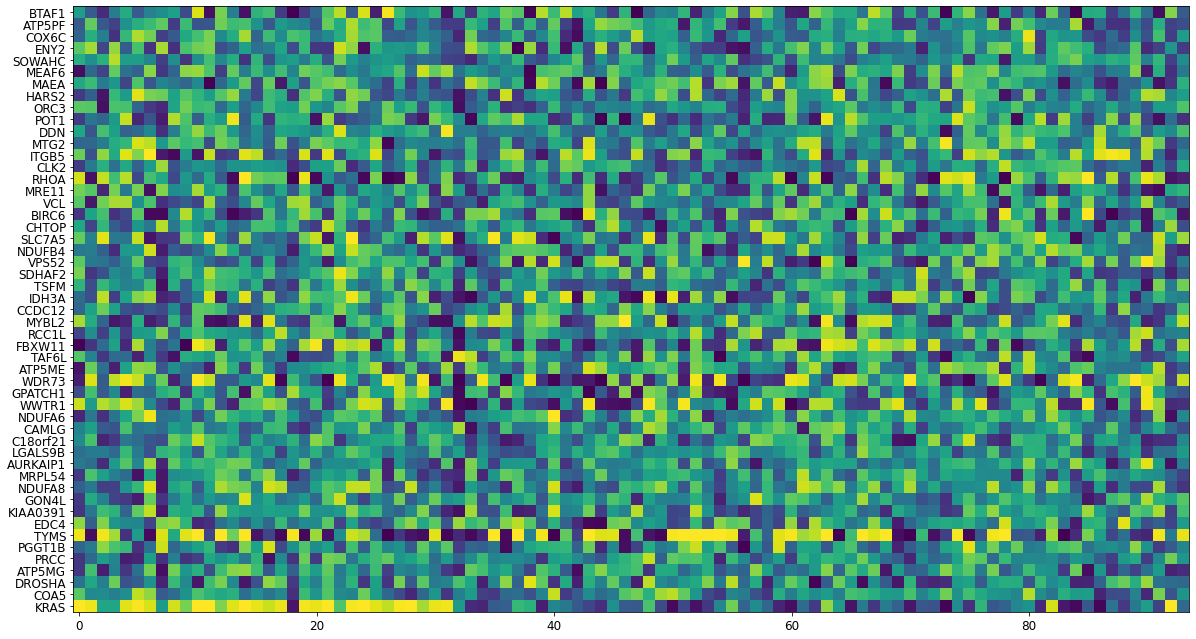

In [381]:
genes = list(to_show.index) + ["KRAS"]

fig, ax = plt.subplots()
plt.rcParams.update({"figure.figsize": (20, 40)})
dat = pd.concat([kras_mt.dependency_of(genes), kras_wt.dependency_of(genes)], axis = 1)
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)
im = ax.imshow(dat)

In [403]:
import scipy.stats as stats

save = {}

d = lung.effect_of("TYMS").drop(bad)

for i in to_show.index:
    e = lung.effect_of(i).drop(bad)
    idx = set(e.index) & set(d.index)
    r, p, = stats.pearsonr(e.loc[idx], d.loc[idx])
    if p < 0.05:
        save[i] = [r, p]

In [408]:
res = pd.DataFrame.from_dict(save).T
res.columns = ['r', 'p']

In [436]:
tyms = can.CellLineCluster(lung.dependent("TYMS"))
non = can.CellLineCluster(lung.non_dependent("TYMS"))



In [464]:
t_muts = tyms.mutations.loc[tyms.mutations.Variant_Classification != "Silent"]
t_counts = t_muts.gene.value_counts()
t_rate = t_counts / len(tyms.depmap_ids)

t = pd.concat([t_counts, t_rate], axis=1)
t.columns = ["t_count", "t_rate"]

n_muts = non.mutations.loc[non.mutations.Variant_Classification != "Silent"]
n_counts = n_muts.gene.value_counts()
n_rate = n_counts / len(non.depmap_ids)

n = pd.concat([n_counts, n_rate], axis=1)
n.columns = ["n_count", "n_rate"]

df = pd.concat([t, n], axis=1).fillna(0)

df.t_rate.subtract(df.n_rate).sort_values(ascending=False).iloc[:20]

TTN        1.556463
USH2A      0.681633
MUC16      0.677098
CSMD3      0.548299
FAT3       0.544218
MUC17      0.451247
ABCA13     0.408617
NEB        0.365986
CSMD2      0.354649
PKHD1L1    0.332426
NRXN1      0.332426
RYR2       0.318821
BIRC6      0.317460
LRP1B      0.314739
UBR5       0.302494
MYO18B     0.295238
CUBN       0.295238
XIRP2      0.269841
UNC80      0.269388
PTPRZ1     0.263492
dtype: float64

In [466]:
df.iloc[:50].loc["BIRC6"]

t_count    21.000000
t_rate      0.428571
n_count     5.000000
n_rate      0.111111
Name: BIRC6, dtype: float64

In [469]:
df.loc["ABCA13"]
n_muts.loc[n_muts.gene == "BIRC6", ["Variant_Classification", "Variant_Type", "DepMap_ID"]].DepMap_ID.unique()

array(['ACH-000861', 'ACH-000888', 'ACH-000900', 'ACH-001233'],
      dtype=object)

In [468]:
t_muts.loc[t_muts.gene == "BIRC6", ["Variant_Classification", "Variant_Type", "DepMap_ID"]].DepMap_ID.unique()

array(['ACH-000282', 'ACH-000378', 'ACH-000416', 'ACH-000454',
       'ACH-000585', 'ACH-000718', 'ACH-000769', 'ACH-000781',
       'ACH-000851', 'ACH-000878', 'ACH-000886', 'ACH-000901',
       'ACH-000916', 'ACH-000924', 'ACH-000975', 'ACH-000980'],
      dtype=object)